In [130]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
import cv2
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow
from copy import deepcopy

In [132]:
!ls


drive  picture	sample_data


In [133]:
image = cv2.imread('/content/drive/My Drive/CoinChecker/image1.jpg')

# для использования кругов Хафа необходимо преобразовать изображение
# resize image while retaining aspect ratio
d = 1024 / image.shape[1]
dim = (1024, int(image.shape[0] * d))
image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

returns circles: A vector that stores x, y, r for each detected circle.

dp: The inverse ratio of resolution

min_dist: Minimum distance between detected centers

param_1: Upper threshold for the internal Canny edge detector

param_2: Threshold for center detection.

min_radius: Minimum radius to be detected.

max_radius: Maximum radius to be detected.

In [134]:
def MyHoughCircles(image, dp=2.2, minDist=30, param1=170, param2=100, minRadius=20, maxRadius=70):

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # improve contrast accounting for differences in lighting conditions:
  # create a CLAHE object to apply contrast limiting adaptive histogram equalization
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  gray = clahe.apply(gray)

  # blur the image using Gaussian blurring, where pixels closer to the center
  # contribute more "weight" to the average, first argument is the source image,
  # second argument is kernel size, third one is sigma (0 for autodetect)
  # we use a 7x7 kernel and let OpenCV detect sigma
  blurred = cv2.GaussianBlur(gray, (7, 7), 0)

  circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=dp, minDist=minDist, 
                           param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
  return circles

In [135]:
def get_image_with_circles(image, circles):

  assert len(circles) > 0, "На фото не найдено окружностей"
  image_with_circles = deepcopy(image)

  for	crc in circles[0,:]:
				#	draw	the	outer	circle
				cv2.circle(image_with_circles,(crc[0],crc[1]),crc[2],(255,0,0),2)
				#	draw	the	center	of	the	circle
				cv2.circle(image_with_circles,(crc[0],crc[1]),2,(0,0,255),3)
    
  return image_with_circles

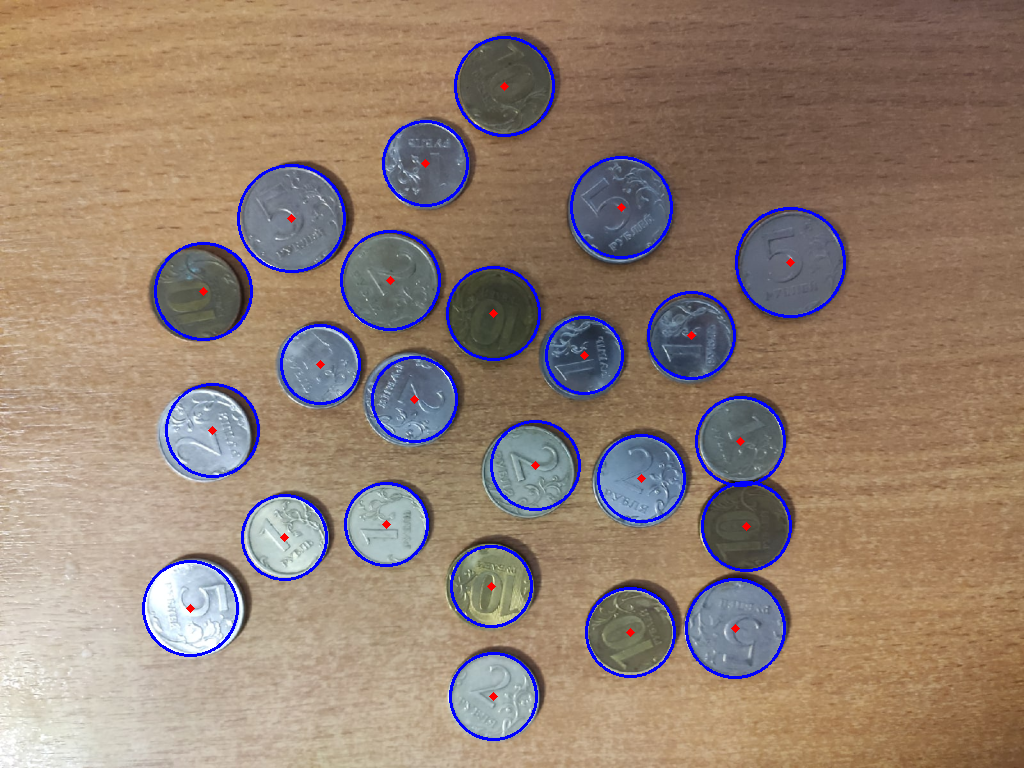

In [136]:
circles = MyHoughCircles(image)

image_with_circles = get_image_with_circles(image, circles)
cv2_imshow(image_with_circles)

In [137]:
circles

array([[[735.9     , 628.10004 ,  49.260002],
        [493.90002 , 696.3     ,  43.54    ],
        [291.5     , 218.90001 ,  53.22    ],
        [641.3     , 478.5     ,  43.98    ],
        [790.9     , 262.9     ,  54.100002],
        [190.3     , 608.3     ,  47.940002],
        [284.9     , 537.9     ,  42.      ],
        [212.3     , 430.1     ,  46.620003],
        [425.7     , 163.90001 ,  42.660004],
        [630.3     , 632.5     ,  44.420002],
        [390.5     , 280.5     ,  49.260002],
        [203.5     , 291.5     ,  48.379997],
        [746.9     , 526.9     ,  44.420002],
        [621.5     , 207.90001 ,  50.14    ],
        [320.1     , 364.1     ,  39.36    ],
        [386.1     , 524.7     ,  41.56    ],
        [493.90002 , 313.5     ,  46.84    ],
        [414.7     , 399.30002 ,  42.      ],
        [504.90002 ,  86.9     ,  49.04    ],
        [740.3     , 441.1     ,  44.420002],
        [691.9     , 335.5     ,  43.32    ],
        [535.7     , 465.30002 ,  

In [138]:
import torch
import torchvision
from torchvision import models

model = models.resnet152()
model.fc = torch.nn.Linear(model.fc.in_features, 4)
model.load_state_dict(torch.load('/content/drive/My Drive/CoinChecker/coins-v2.pth'))
model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

FileNotFoundError: ignored

In [ ]:
from torchvision import transforms

dataset_transforms = {
                      'orig': transforms.Compose([
    transforms.Resize((224, 224)),
#    transforms.Grayscale(num_output_channels=3), ##############
#    transforms.RandomRotation(180), #######################
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])}

In [ ]:
class_names = ['10_rubles', '1_rubles', '2_rubles', '5_rubles']

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder): #Создаем класс, он наследуется от ImageFolder, но изменяет его функцию get_item
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index) #Дополняем original_tuple путем для файла (.__getitem__(index))
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
from tqdm import tqdm

def get_prediction():
  for (i,tranforms) in dataset_transforms.items():
    test_dataset = ImageFolderWithPaths('./picture', tranforms) #Берем новый класс и получаем tuple из 3х значений
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=16, shuffle=False, num_workers=0) #Новый даталоадер с путями до изображений
    
    model.eval() #Переводим модель в состояние eval
    for inputs, labels, paths in tqdm(test_dataloader): #Цикл по test_dataloader inputs - батч с изображением, lable - тут none, paths - пути до изображения  
        inputs = inputs.to(device) 
        labels = labels.to(device)  
        with torch.set_grad_enabled(False):
            preds = model(inputs) # Считаем предикшены
        label = torch.argmax(preds)
    return class_names[label]

In [ ]:
circles = np.round(circles[0, :]).astype("int")

In [ ]:
import os

if not os.path.isdir('picture'):
  os.mkdir('picture')

if not os.path.isdir('picture/1_rubles'):
  os.mkdir('picture/1_rubles')

In [ ]:
total = 0
for x, y, r in circles:
  r += 4 # for heap
  roi = image[y - r:y + r, x - r:x + r]
  im = Image.fromarray(roi)

  im.save('picture/1_rubles/picture.jpg', 'JPEG')

  label = get_prediction()

  if label == '10_rubles':
    total += 10
    cv2.putText(image_with_circles, str(label[:2]),
                    (x - int(r/5), y + int(r/2)), cv2.FONT_HERSHEY_PLAIN,
                    1.5, (0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
  else:
    total += int(label[:1])
    cv2.putText(image_with_circles, str(label[0]),
                    (x - int(r/5), y + int(r/2)), cv2.FONT_HERSHEY_PLAIN,
                    1.5, (0, 0, 255), thickness=2, lineType=cv2.LINE_AA)

100%|██████████| 1/1 [00:00<00:00, 48.02it/s]


In [ ]:
cv2.putText(image_with_circles, "Summary: " + str(total),
            (5, image_with_circles.shape[0] - 24), cv2.FONT_HERSHEY_PLAIN,
            1.0, (0, 0, 255), lineType=cv2.LINE_AA)

array([[[ 87, 138, 181],
        [ 86, 138, 179],
        [ 86, 137, 178],
        ...,
        [ 71,  79, 102],
        [ 75,  83, 106],
        [ 74,  82, 105]],

       [[ 89, 140, 183],
        [ 89, 141, 183],
        [ 91, 142, 183],
        ...,
        [ 67,  75,  98],
        [ 69,  77, 100],
        [ 67,  75,  98]],

       [[ 89, 140, 183],
        [ 90, 141, 184],
        [ 92, 142, 184],
        ...,
        [ 65,  73,  96],
        [ 67,  75,  98],
        [ 65,  73,  96]],

       ...,

       [[242, 240, 240],
        [249, 248, 248],
        [234, 233, 233],
        ...,
        [ 48,  74, 110],
        [ 48,  74, 110],
        [ 49,  75, 111]],

       [[254, 253, 253],
        [254, 254, 254],
        [249, 249, 249],
        ...,
        [ 48,  74, 110],
        [ 48,  74, 110],
        [ 49,  75, 111]],

       [[253, 252, 252],
        [246, 245, 245],
        [219, 218, 218],
        ...,
        [ 48,  74, 110],
        [ 49,  75, 111],
        [ 49,  75, 111]]

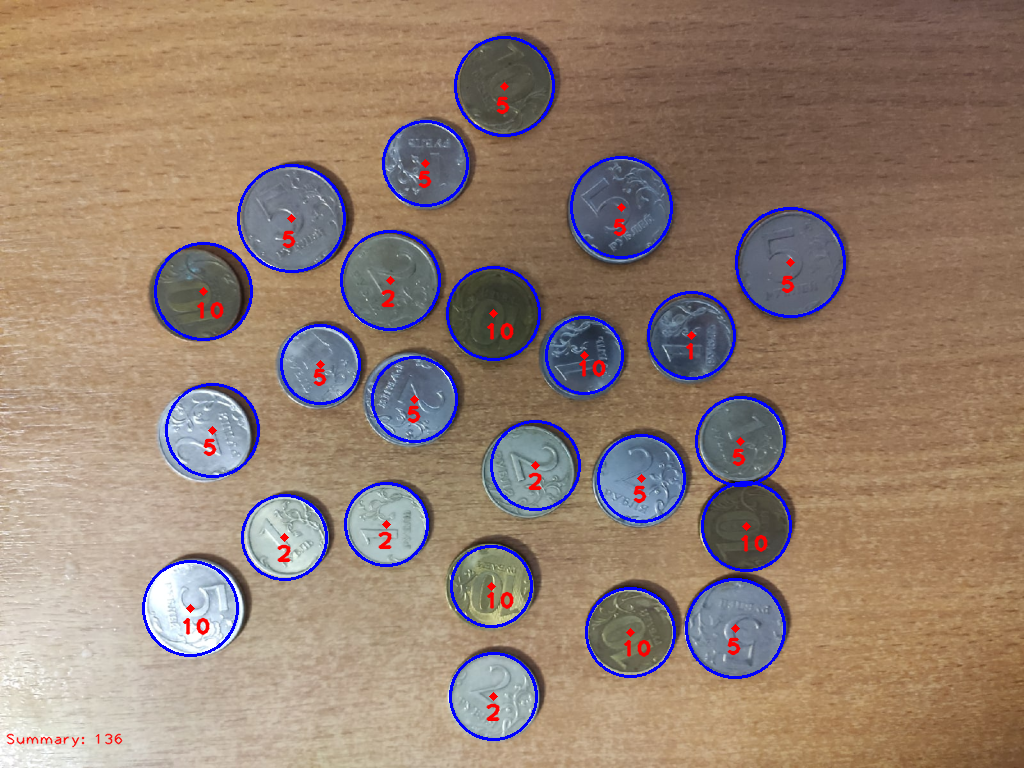

In [ ]:
cv2_imshow(image_with_circles)